In [184]:
#update libs
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade pprint
!pip install --upgrade hyperopt
!pip install --upgrade hpsklearn
!pip install --upgrade seaborn

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.23.4)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: hyperopt in c:\anaconda\lib\site-packages (0.1.1)
Requirement already up-to-date: hpsklearn in c:\anaconda\lib\site-packages (0.1.0)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)


In [185]:
#import common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import inflect
import itertools
from pprint import pprint
from tqdm import tqdm
import glob

#from scipy import interp
sns.set(font_scale=1.3)

In [50]:
#import special libs
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix, recall_score, brier_score_loss
from sklearn.metrics import f1_score, make_scorer, precision_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD,IncrementalPCA

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.calibration import CalibratedClassifierCV, calibration_curve


%matplotlib inline

In [51]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords
from nltk import ngrams

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

from sklearn.datasets import fetch_20newsgroups
seed = 321

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


Загрузим датасет с классифицируемыми текстами.

In [265]:
# здесь shuffle = true, т.к. мы собираемся использовать SGDClassifier; Naive Bayes - они базируются на принципе iid данных 
#и чтобы не получить смещенную оценку
newsgroups_all = fetch_20newsgroups(subset='all', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
train_texts = fetch_20newsgroups(subset='train', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
test_texts = fetch_20newsgroups(subset='test', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

Итак, задача данной работы:



#### EDA.

Посмотрим на данные, для этого:
- посмотрим на категории текстов
- распределение документов по категориям
- посмотрим на примеры данных

In [266]:
pprint("%d documents" % len(newsgroups_all.data))
pprint("%d categories" % len(newsgroups_all.target_names))

'18846 documents'
'20 categories'


In [387]:
def generate_stat_df(df,df_type):
    unique, counts = np.unique(df.target, return_counts=True)

    df_print = pd.DataFrame(data=list(zip(unique, df.target_names, counts)), 
                            columns = ['Id_category', 'Category_Name', 'N_texts'])
    df_print['High_level_topic'] = df_print["Category_Name"].str.split(".", expand = True)[0]
    df_print['Dataset_Type'] = df_type
    return df_print

df_summary = generate_stat_df(train_texts, 'train')
df_summary = df_summary.append(generate_stat_df(test_texts, 'test'), ignore_index=True)
df_summary = df_summary.append(generate_stat_df(newsgroups_all, 'all'), ignore_index=True)

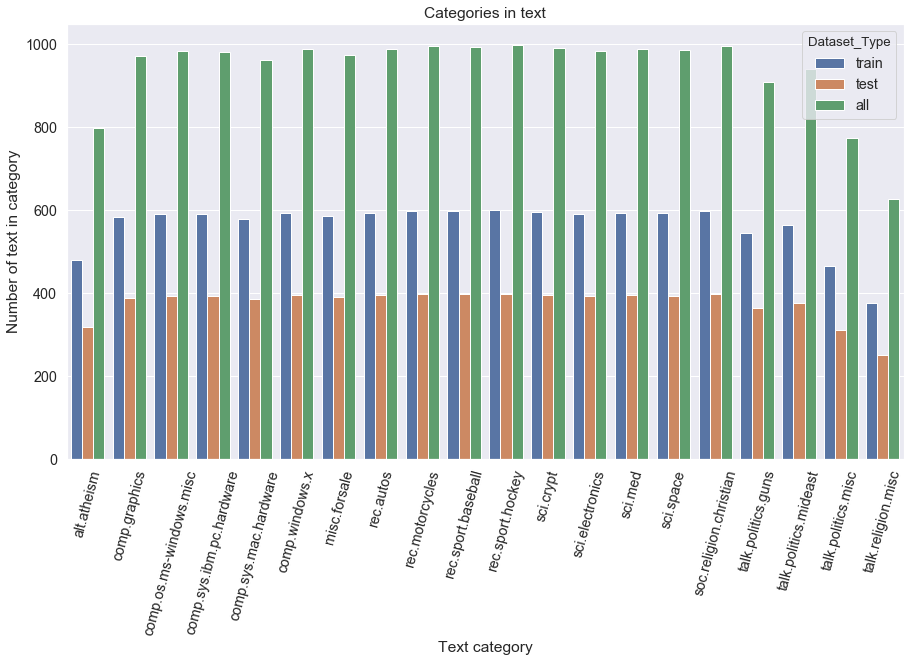

In [388]:
# print the histogramm with distribution of texts by categorieas and topics
plt.figure(figsize=(15,8))
sns.barplot(x="Category_Name", y="N_texts", hue = 'Dataset_Type',data=df_summary)
plt.xticks(rotation=75)
plt.xlabel('Text category');
plt.ylabel('Number of text in category');
plt.title("Categories in text");

                   0     1      2     3     4      5     6     7      8   \
High_level_topic  alt   alt    alt  comp  comp   comp  misc  misc   misc   
Dataset_Type      all  test  train   all  test  train   all  test  train   
N_texts           799   319    480  4891  1955   2936   975   390    585   

                    9   ...       11    12    13     14   15    16     17  \
High_level_topic   rec  ...      rec   sci   sci    sci  soc   soc    soc   
Dataset_Type       all  ...    train   all  test  train  all  test  train   
N_texts           3979  ...     2389  3952  1579   2373  997   398    599   

                    18    19     20  
High_level_topic  talk  talk   talk  
Dataset_Type       all  test  train  
N_texts           3253  1301   1952  

[3 rows x 21 columns]


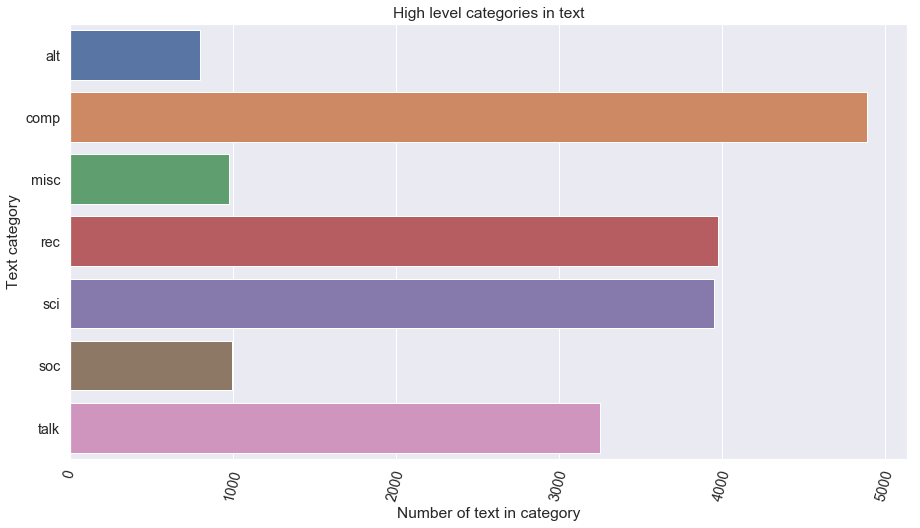

In [389]:
groupped_df = df_summary.groupby(['High_level_topic','Dataset_Type']).agg({'N_texts': ['sum']})
groupped_df.columns = groupped_df.columns.droplevel(1)
groupped_df.reset_index(inplace=True)
print(groupped_df.T)


plt.figure(figsize=(15,8))
sns.barplot(x="N_texts", y="High_level_topic", data=groupped_df[groupped_df.Dataset_Type == 'all'])
plt.xticks(rotation=75)
plt.xlabel('Number of text in category');
plt.ylabel('Text category');
plt.title("High level categories in text");

Посмотрим на образец данных.

In [391]:
pprint(newsgroups_all.data[11])

('\n'
 'This is a ridiculous argument for being a Christian.  So then, you might \n'
 'consider switching from Christianity to another religion if you were \n'
 'offered an even more frightening description of another hell?  How many\n'
 'Christians do think there are who view it strictly as an insurance policy?\n'
 'Not many I know; they believe in a message of love and compassion for \n'
 'others.  A faith based on fear of hell sounds like a dysfunctional \n'
 "relationship with God.  Like a child who cringes in fear of a parent's\n"
 'physical violence.  \n'
 '\n'
 'Many religions have concrete views of heaven and hell, with various\n'
 'threats and persuasions regarding who will go where.  Competition over\n'
 'who can envison the worst hell can hardly nurture the idea of loving\n'
 'your neighbor as yourself.\n'
 '\n')


In [392]:
newsgroups_all.target_names[newsgroups_all.target[11]]

'soc.religion.christian'

Текст содержит элементы вида - перенос строки, знаки препинания, имя собественное.

In [393]:
pprint(newsgroups_all.data[55])

('Yo, Whaz up!!!\n'
 '\n'
 'Earlier, I was reading on the net about using Splitfire plugs.  One\n'
 'guy was thinking about it and almost everybody shot him to hell.  Well,\n'
 'I saw one think that someone said about "Show me a team that used Split-\n'
 'fires...."  Well, here\'s some additional insight and some theories\n'
 'about splitfire plugs and how they boost us as oppossed to cages.\n'
 '\n'
 'Splitfires were originally made to burn fuel more efficiently and\n'
 'increased power for the 4x4 cages.  Well, for these guys, splitfires\n'
 "increased performance by increasing TORQUE.  They weren't focusing\n"
 'on horsepower numbers.\n'
 '\n'
 'Now how does this related to us high performance pilots?  Well, that\n'
 'depends.  Do you pilot a high performance 2- or 4-cylinder machine?\n'
 'In the case of 4-cylinders, splitfires would increase overall torque,\n'
 "but 4's make more top end horsepower with its torque packed down low.\n"
 "So for 4's, splitfires would not significantly

In [394]:
newsgroups_all.target_names[newsgroups_all.target[55]]

'rec.motorcycles'

Помимо элементов из предыдущего текста здесь добавились ..., почтовый адрес и другие шумовые "элементы".

#### Data preprocessing.

Предобработаем данные, для этого:
- приведем все слова к нижнему регистру+.
- удалим знаки препинания+.
- заменим представление чисел в виде цифр на текстовые аналоги+.
- отсечем стоп слова (уберем символы и комбинации, которые не составляют смысловой нагрузки)+.
- проведем лемматизацию/стемминг (приведение слова к начальной форме с помощью словаря/выделение корня слова)+.
- удалим слова длиной 2 и менее символов+.
- выделим n-граммы (последовательности из нескольких слов, рассматриваемых как одно целое).

In [788]:
def remove_emails(text):
    text = re.sub('\S*@\S*\s?','',text)
    #text =  re.sub('\n', '',text)
    #text =  re.sub('\t', '',text)
    
    return text

In [789]:
def remove_punctuation(text_punctuation,text):
    
    new_text = []
    #new_text = re.sub('['+text_punctuation+']', '',text)
    #new_text = re.sub('\n', ' ',new_text)
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)
    
    return new_text

In [790]:
def digits_to_text(text):
    p = inflect.engine()
    new_text = []
    for word in text:
        if word.isdigit():
            if len(word) > 18:
                print (1) #do nothing
            else:
                new_word = p.number_to_words(word)
                new_text.append(new_word)
        else:
            new_text.append(word)
    #del p
    return new_text

In [791]:
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='v') # pay attention to pos='v' parameter!
        new_text_lemma.append(lemma)
        
        stemm = stemmer.stem(word)
        new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

In [792]:
StopWords = list(set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS)))
newStopWords = ['jfc','jb'] # по ходу работы периодически добавляем стоп-слова
newStopWords2 = ['arent', 'didnt', 'doesnt', 'dont', 'hadnt', 'havent', 'isnt', 
                 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'theres','thatll', 'wasnt', 
                 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve',
                 "'ll", "'re", "'ve", "n't", 'need', 'sha', 'anna','n t','ann mari', 'ann marie', 
                 'anna diana', 'anna diane', 'anna maria', 'anne corinne', 'anne mar', 'anne marie', 
                 'barbara anne', 'bette ann', 'carol jean', 'diane marie', 'e lane', 'hans peter', 
                 'helen elizabeth', 'holly anne', 'jean christophe', 'jean francois', 'jean lou', 
                 'jean luc', 'jean marc', 'jean paul', 'jean pierre', 'jo anne', 'john david', 'john patrick', 
                 'kara lynn', 'marie ann', 'marie jeanne', 'paula grace', 'sara ann', 
                 'sheila kathryn', 'sue elle', 'terri jo', 'theresa marie', 'zsa']
StopWords.extend(newStopWords)
StopWords.extend(newStopWords2)


male_names = names.words('male.txt')
female_names = names.words('female.txt')

Common_First_Names = list(set(male_names).union(set(female_names)))
Common_First_Names = list(map(lambda word: word.lower(), Common_First_Names))

StopWords.extend(Common_First_Names)

def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

In [793]:
def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text

In [803]:
# getting source from string.punctuation, but removed right slash / and ^
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~'

def tokenize(text):
    min_length = 3
    
    # remove emails from text to prevent overfit
    text = remove_emails(text)
    #  text  to lowercase
    text =  text.lower()
    
    #remove punctuation
    #text = remove_punctuation(text_punctuation, text) 
    
    #ngrams test
    #words = list(ngrams(text.split(), 3))

    # tokenize text
    words = word_tokenize(text,language='english')
    
    #remove punctuation
    words = remove_punctuation(text_punctuation, words)   
    
    #replace digits with words
    words = digits_to_text(words)
        
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize or stemm words 
    words,_ = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 3)

    return words

In [804]:
'''

sentence = 'this is a foo bar sentences and i want to ngramize it'

n = 3
sixgrams = ngrams(sentence.split(), n)

for grams in sixgrams:
  print (grams)''';

In [805]:
pprint(newsgroups_all.data[55]) #1,3,5

('Yo, Whaz up!!!\n'
 '\n'
 'Earlier, I was reading on the net about using Splitfire plugs.  One\n'
 'guy was thinking about it and almost everybody shot him to hell.  Well,\n'
 'I saw one think that someone said about "Show me a team that used Split-\n'
 'fires...."  Well, here\'s some additional insight and some theories\n'
 'about splitfire plugs and how they boost us as oppossed to cages.\n'
 '\n'
 'Splitfires were originally made to burn fuel more efficiently and\n'
 'increased power for the 4x4 cages.  Well, for these guys, splitfires\n'
 "increased performance by increasing TORQUE.  They weren't focusing\n"
 'on horsepower numbers.\n'
 '\n'
 'Now how does this related to us high performance pilots?  Well, that\n'
 'depends.  Do you pilot a high performance 2- or 4-cylinder machine?\n'
 'In the case of 4-cylinders, splitfires would increase overall torque,\n'
 "but 4's make more top end horsepower with its torque packed down low.\n"
 "So for 4's, splitfires would not significantly

In [806]:
%%time
test = tokenize(newsgroups_all.data[55])

Wall time: 46.9 ms


In [807]:
test

['whaz',
 'earlier',
 'read',
 'net',
 'use',
 'splitfire',
 'plug',
 'think',
 'everybody',
 'shoot',
 'hell',
 'think',
 'say',
 'team',
 'use',
 'split',
 'fire',
 'additional',
 'insight',
 'theories',
 'splitfire',
 'plug',
 'boost',
 'oppossed',
 'cage',
 'splitfires',
 'originally',
 'burn',
 'fuel',
 'efficiently',
 'increase',
 'power',
 '4x4',
 'cage',
 'guy',
 'splitfires',
 'increase',
 'performance',
 'increase',
 'torque',
 'focus',
 'horsepower',
 'number',
 'relate',
 'high',
 'performance',
 'pilot',
 'depend',
 'pilot',
 'high',
 'performance',
 '4 cylinder',
 'machine',
 '4 cylinders',
 'splitfires',
 'increase',
 'overall',
 'torque',
 'make',
 'end',
 'horsepower',
 'torque',
 'pack',
 'low',
 'splitfires',
 'significantly',
 'increase',
 'power',
 'twin',
 'guy',
 'laugh',
 'twin',
 'time',
 'weight',
 'make',
 'loss',
 'polen',
 'daytona',
 'one thousand, nine hundred and ninety-two',
 'twin',
 'make',
 'torque',
 'thoughout',
 'powerbands',
 'translate',
 'incre

После того, как проверили работу токенизатора, извлечем фичи из текста с использованием TF-IDF.

Выделим для этого метки для трейн/тест датасетов.

In [616]:
y_train, y_test = train_texts.target, test_texts.target

In [820]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             #min_df=0.05, # ignore terms with freq more that 0.05, lower majoring
                             #max_df=0.90, # ignore terms with freq more that 0.9, upper majoring
                             #max_features=3000,
                             use_idf=True,  #need this parameter
                             sublinear_tf=True,
                             norm='l2',
                             ngram_range= (1, 3)
                            )

In [821]:
%%time
vectorised_train_documents = vectorizer.fit_transform(train_texts.data)
vectorised_test_documents = vectorizer.transform(test_texts.data)

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ann mari', 'ann marie', 'anna diana', 'anna diane', 'anna maria', 'anne corinne', 'anne mar', 'anne marie', 'barbara anne', 'bette ann', 'carol jean', 'diane marie', 'e lane', 'hans peter', 'helen elizabeth', 'holly anne', 'jean christophe', 'jean francois', 'jean lou', 'jean luc', 'jean marc', 'jean paul', 'jean pierre', 'jo anne', 'john david', 'john patrick', 'kara lynn', 'marie ann', 'marie jeanne', 'paula grace', 'sara ann', 'sheila kathryn', 'sue elle', 'terri jo', 'theresa marie', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 9min 37s


Напишем функцию, которая будет производить:
- извлечение фич.
- вывод результатов работы классификатора.
- производить кросс-валидацию по 5 фолдам.

In [619]:
results_df = []
results_df = pd.DataFrame(columns=('Algorithm', 'Train_score', 'Test_score_cv', 'parameters'))

In [620]:
#variant with pipeline and cv
'''def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    tfidf_params = {
        'stop_words' : StopWords,
        'tokenizer':tokenize,
        'use_idf':True,
        'sublinear_tf':True,
        'norm':'l2'
    }
    clf = Pipeline([('vect', TfidfVectorizer(** tfidf_params)), ('classifier', classifier)])
    
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    #pred_test = clf.predict(X_test)
    #f1_test = f1_score(y_test, pred_test, average='micro')
    
    my_scorer = make_scorer(f1_score, average='weighted')
    skv = StratifiedKFold(n_splits = 3,random_state=seed, shuffle=True)
    f1_test = cross_val_score(clf, X_test, y_test, cv=skv, scoring=my_scorer,n_jobs = -1).mean()
    
    return f1_train, f1_test


alphas = [0.01 , 0.015, 0.02]

for alph in tqdm(alphas):
    a = "MultinomialNB"
    b,c = classify_and_score(MultinomialNB(alpha=alph), train_texts.data, 
                           test_texts.data, y_train, y_test)
    d = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':a, 'Train_score':b,'Test_score_cv':c, 'parameters':d},ignore_index=True)
    
    ''';

In [621]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(20,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [622]:
#simple variant
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='micro')
    
    return f1_train, f1_test, clf

Проверим работу алгоритмов:
- MultinomialNB
- BernoulliNB

In [ ]:
#actual block of code
alphas = [0.0001,0.001,0.005 ,0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,2,5]

for alph in alphas:
    f_el = "MultinomialNB"
    s_el,t_el,_ = classify_and_score(MultinomialNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)

In [ ]:
for alph in alphas:
    f_el = "BernoulliNB"
    s_el,t_el,_ = classify_and_score(BernoulliNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)

In [ ]:
best_param = results_df[results_df.Test_score_cv >=  results_df.Test_score_cv.max()]['parameters'].values[0]
print (results_df[results_df.Test_score_cv >=  results_df.Test_score_cv.max()])


                          precision    recall  f1-score   support

             alt.atheism       0.50      0.35      0.41       319
           comp.graphics       0.49      0.53      0.51       389
 comp.os.ms-windows.misc       0.52      0.47      0.49       394
comp.sys.ibm.pc.hardware       0.47      0.57      0.52       392
   comp.sys.mac.hardware       0.53      0.46      0.50       385
          comp.windows.x       0.55      0.57      0.56       395
            misc.forsale       0.71      0.70      0.70       390
               rec.autos       0.55      0.48      0.51       396
         rec.motorcycles       0.62      0.44      0.52       398
      rec.sport.baseball       0.71      0.59      0.64       397
        rec.sport.hockey       0.32      0.77      0.45       399
               sci.crypt       0.57      0.61      0.59       396
         sci.electronics       0.45      0.34      0.39       393
                 sci.med       0.64      0.49      0.56       396
         

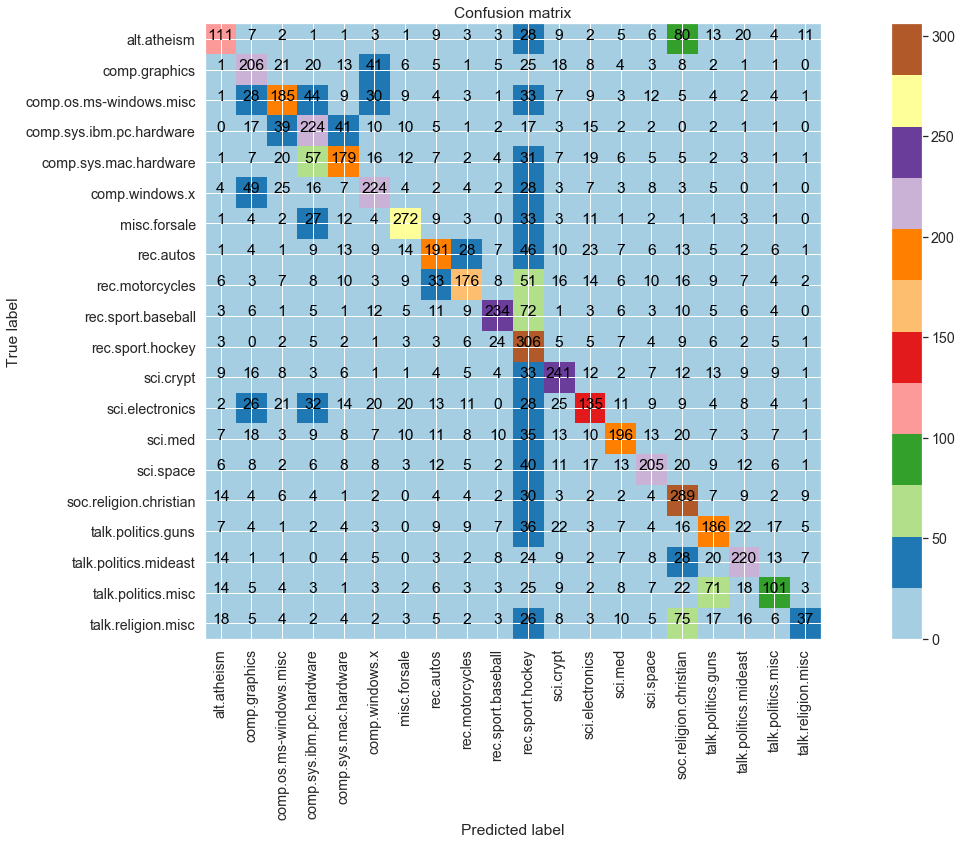

In [815]:
_,_,clf =  classify_and_score(MultinomialNB(alpha = 0.025), vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,target_names = newsgroups_all.target_names))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = newsgroups_all.target_names))


In [818]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [819]:
show_most_informative_features(vectorizer, clf, n = 30)

	-14.3501	/                                                                          \ history		-9.9393	stay blow bronx
	-14.3501	/                                                                          \ history user visible		-9.9393	stay blow      
	-14.3501	/                                                                       / display		-9.9393	sink manhattan sea
	-14.3501	/                                                                       / display dpy		-9.9393	sink manhattan 
	-14.3501	/                                                                      / void		-9.9393	queen stay blow
	-14.3501	/                                                                      / void tselect		-9.9393	queen stay     
	-14.3501	/                / /                /		-9.9393	manhattan sea  
	-14.3501	/                / /                / /                /		-9.9393	bronx away sink
	-14.3501	/                / /                / /      /\        /		-9.9393	bronx away     
	-14.3501	/    

- LinearSVC

#what if l1,l2 or ...loss?

In [120]:
%%time
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0, 20.0]

for c in C_values:
    f_el = "LinearSVC"
    s_el,t_el,_ = classify_and_score(LinearSVC(C=c,random_state=seed,max_iter = 10e3,class_weight = 'balanced'), 
                                   vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)

- SVC Kernel Poly

In [128]:
%%time
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0, 20.0, 40.0, 60.0, 100.0]

for c in tqdm(C_values):
    f_el = "SVC_poly"
    s_el,t_el,_ = classify_and_score(SVC(kernel='poly',gamma='scale',C=c,random_state=seed,class_weight = 'balanced'), 
                                   vectorised_train_documents, vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:12<00:00, 138.94s/it]


- SVC Kernel Sigmoid and RBF

In [ ]:
kernel = ['rbf','sigmoid']
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.4, 0.5,  0.8, 1.0, 2.0, 5.0, 10.0]

for kern in tqdm(kernels):
    for c in tqdm(C_values):
        f_el = "SVC_" + kern
        s_el,t_el,_ = classify_and_score(SVC(kernel=kern,gamma='scale',C=c,random_state=seed,class_weight = 'balanced'), 
                                       vectorised_train_documents, vectorised_test_documents, y_train, y_test)
        f0_el = "C = " + str(c) + " Kernel = " + kern

        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)

In [190]:
results_df[results_df.Test_score_cv >=  results_df.Test_score_cv.max()]

,Algorithm,Train_score,Test_score_cv,parameters
29,MultinomialNB,0.948619,0.673413,alpha = 0.07


In [242]:
results_df.to_csv("results_df.csv", sep=';', encoding='utf-8',index = False, header = True)

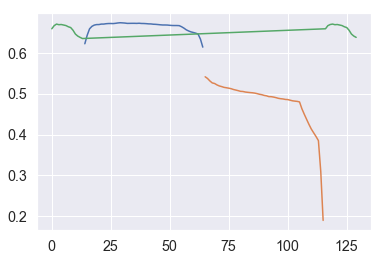

In [240]:
#sns.lineplot(x=results_df.Test_score_cv, hue="Algorithm", lw=1, data=results_df)
#ax = sns.lineplot(y = 'Test_score_cv',data = results_df)
#sns.lineplot(x = results_df.Test_score_cv,data = results_df)
#plt.plot(results_df[results_df.Algorithm == 'SVC_poly']['Test_score_cv'])

In [697]:
#drop svc results
results_df = results_df[results_df.Algorithm !='SGD']

In [712]:
sgd_clf = SGDClassifier(loss = 'modified_huber', penalty = 'elasticnet',
                        alpha = 0.0001, l1_ratio = 0.15,
                        max_iter = 1000, tol = 1e-4,
                        n_jobs = -1, random_state = seed,
                        learning_rate = 'optimal', #adaptive - no profit
                        class_weight = 'balanced', shuffle = True,
                        n_iter_no_change = 100, early_stopping = True
             )

In [723]:
losses = ['hinge','log','modified_huber','squared_hinge','perceptron']
penalties = ['l1','l2','elasticnet']
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3 , 5]
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

'''for ls in tqdm(losses):
    f_el = "SGD"
    sgd_clf.loss = ls
    s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                     vectorised_test_documents, y_train, y_test)
    f0_el = "loss = " + ls
    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)''';
for alp in tqdm(alphas):
    for l1 in tqdm(l1_ratios):
        f_el = "SGD"
        sgd_clf.alpha = alp
        sgd_clf.l1_ratio = l1
        s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                         vectorised_test_documents, y_train, y_test)
        f0_el = "alpha = " + str(alp) + " l1_ratio = " + str(l1)
        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)


# compare hinge loss == linear SVM
# compare other different kernels



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


 11%|█████████▎                                                                          | 1/9 [00:08<01:11,  8.89s/it]


 22%|██████████████████▋                                                                 | 2/9 [00:18<01:03,  9.03s/it]


 33%|████████████████████████████                                                        | 3/9 [00:27<00:54,  9.09s/it]


 44%|█████████████████████████████████████▎                                              | 4/9 [00:36<00:45,  9.04s/it]


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:44<00:35,  8.87s/it]


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:57<00:30, 10.02s/it]


 78%|█████████████████

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


 11%|█████████▎                                                                          | 1/9 [00:14<01:56, 14.58s/it]


 22%|██████████████████▋                                                                 | 2/9 [00:30<01:44, 14.98s/it]


 33%|████████████████████████████                                                        | 3/9 [00:43<01:26, 14.49s/it]


 44%|█████████████████████████████████████▎                                              | 4/9 [00:56<01:09, 13.95s/it]


 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:09<00:54, 13.70s/it]


 67%|████████████████████████████████████████████████████████                            | 6/9 [01:21<00:39, 13.27s/it]


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [01:35<00:26, 13.47s/it]


 89%|███████████████████

In [715]:
sgd_clf.loss = 'hinge'
#alpha = 0.0001 l1_ratio = 0.01

In [721]:
sgd_clf

                          precision    recall  f1-score   support

             alt.atheism       0.50      0.49      0.50       319
           comp.graphics       0.64      0.64      0.64       389
 comp.os.ms-windows.misc       0.63      0.59      0.61       394
comp.sys.ibm.pc.hardware       0.63      0.60      0.62       392
   comp.sys.mac.hardware       0.70      0.63      0.66       385
          comp.windows.x       0.81      0.72      0.76       395
            misc.forsale       0.71      0.79      0.75       390
               rec.autos       0.77      0.70      0.74       396
         rec.motorcycles       0.49      0.74      0.59       398
      rec.sport.baseball       0.85      0.79      0.82       397
        rec.sport.hockey       0.87      0.88      0.88       399
               sci.crypt       0.80      0.70      0.75       396
         sci.electronics       0.60      0.55      0.57       393
                 sci.med       0.77      0.79      0.78       396
         

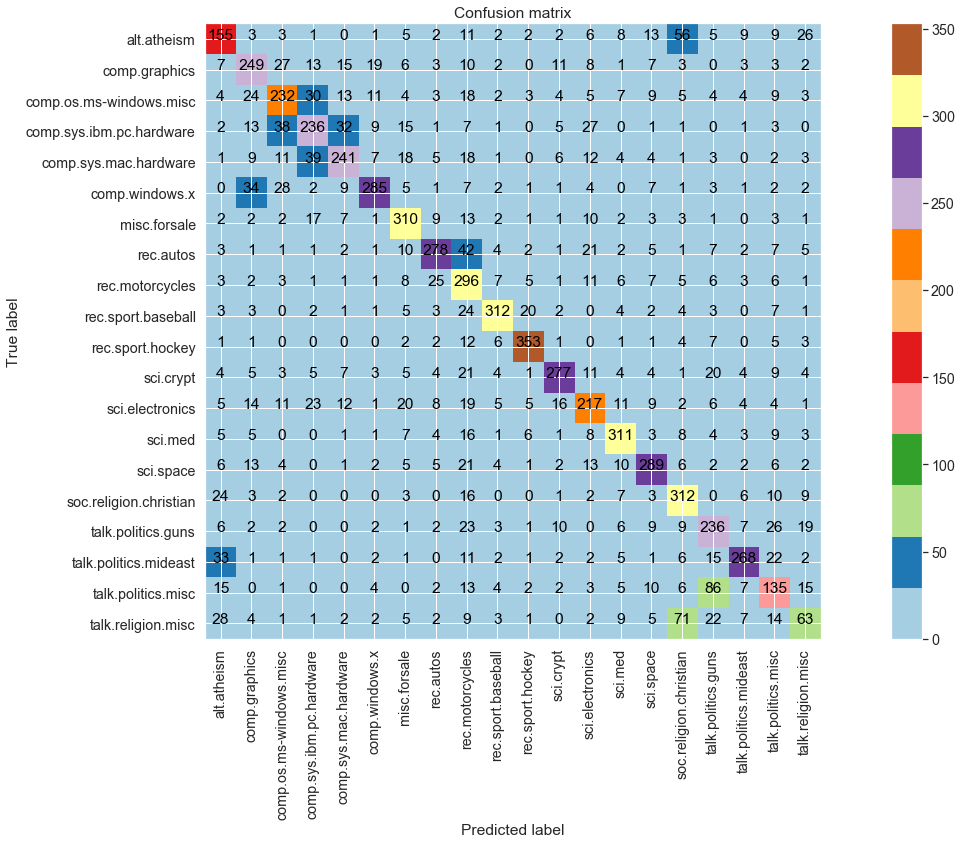

In [717]:
_,_,clf =  classify_and_score(sgd_clf, vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,target_names = newsgroups_all.target_names))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = newsgroups_all.target_names))


GaussianNB не использовался, т.к. на вход этому алгоритму требуется dense, а не sparce-матрица.
При выполнении преобразования todense()/toarray() потребление памяти существенно возросло и привело к тому, что массив не помещяется в память.

In [ ]:
"""clf = GaussianNB()
clf.fit(vectorised_train_documents.toarray(), y_train)
pred = clf.predict(vectorised_test_documents.toarray())
f1_score(y_test, pred, average='micro')""";